In [8]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


STEP 2: Loading and Inspecting Data

First 3 rows:
                 time  generation biomass  \
0 2014-12-31 23:00:00               447.0   
1 2014-12-31 23:00:00               447.0   
2 2014-12-31 23:00:00               447.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 329.0                                 0.0   
2                                 329.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 4844.0                       4821.0                  162.0   
2                 4844.0                       4821.0                  162.0   

   generation fossil oil shale  generation fossil peat  generation geothermal  \
0                          0.0                  

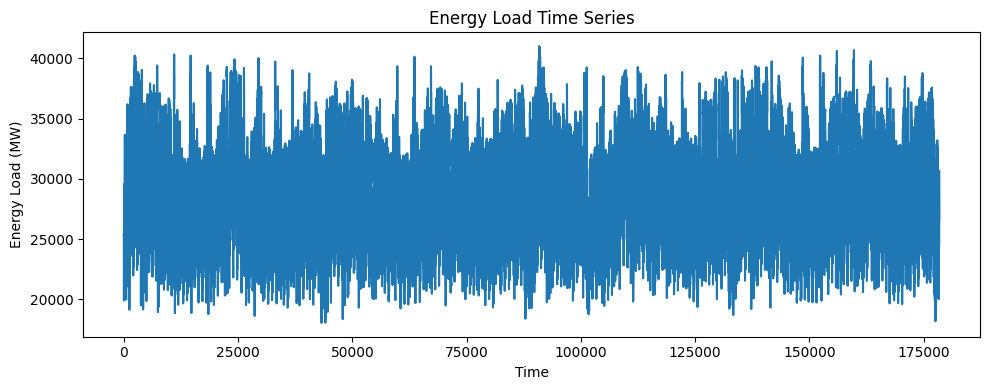


Data Shape: (178396, 41)
Columns: ['time', 'generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'forecast solar day ahead', 'forecast wind offshore eday ahead', 'forecast wind onshore day ahead', 'total load forecast', 'total load actual', 'price day ahead', 'price actual', 'city_name', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']


In [18]:
# 2. Load Dataset with Progress Tracking
print("\nSTEP 2: Loading and Inspecting Data")
data = pd.read_csv('/content/drive/MyDrive/Full_Merged_AllCities_Energy_Weather.csv', parse_dates=['time'])
print("\nFirst 3 rows:")
print(data.head(3))
print("\nData Statistics:")
print(data.describe())

plt.figure(figsize=(10, 4))
data['total load actual'].plot(title='Energy Load Time Series')
plt.xlabel('Time')
plt.ylabel('Energy Load (MW)')
plt.tight_layout()
plt.show()

print("\nData Shape:", data.shape)
print("Columns:", data.columns.tolist())
print("="*50)


STEP 3: Handling Missing Values


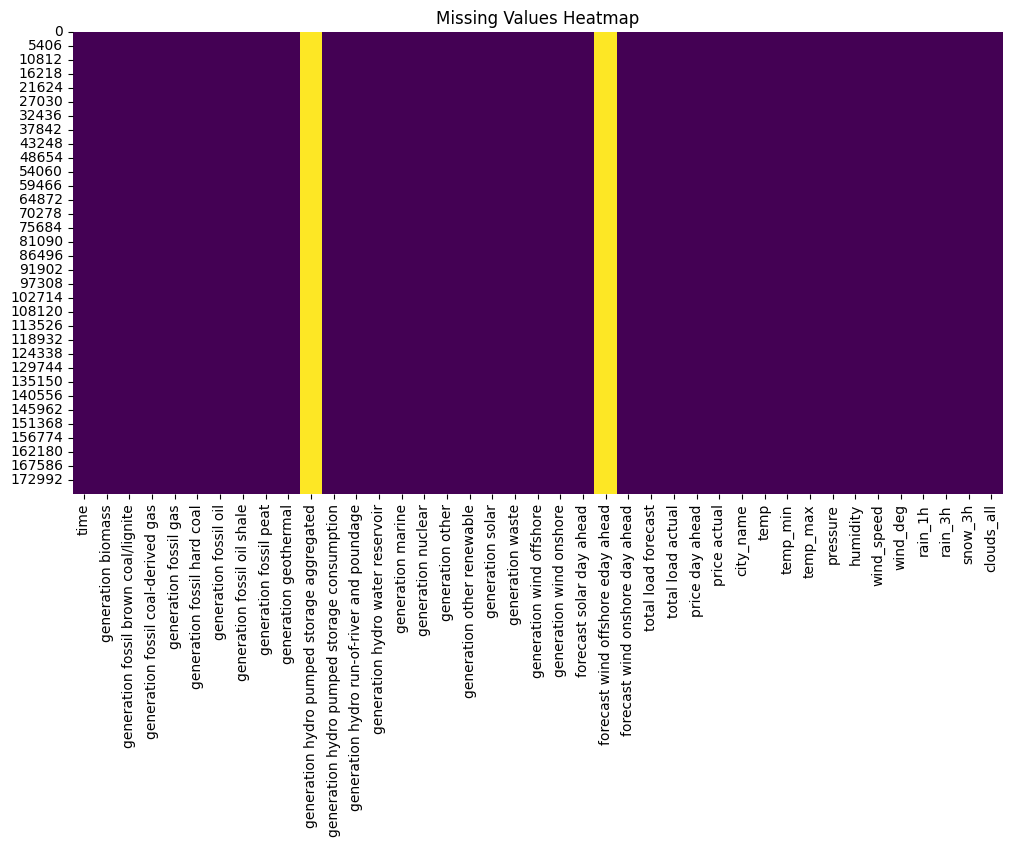


Missing Values Before Handling:
generation hydro pumped storage aggregated     178396
forecast wind offshore eday ahead              178396
total load actual                                 180
generation hydro pumped storage consumption        95
generation biomass                                 95
dtype: int64


<ipython-input-19-217034d69cfd>:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')



Missing Values After Handling:
356792 total missing values remaining


In [19]:
# 3. Data Cleaning with Missing Values Visualization
print("\nSTEP 3: Handling Missing Values")
plt.figure(figsize=(12, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

print("\nMissing Values Before Handling:")
print(data.isnull().sum().sort_values(ascending=False).head())

data = data.fillna(method='ffill').fillna(method='bfill')

print("\nMissing Values After Handling:")
print(data.isnull().sum().sum(), "total missing values remaining")
print("="*50)



STEP 4: Feature Selection


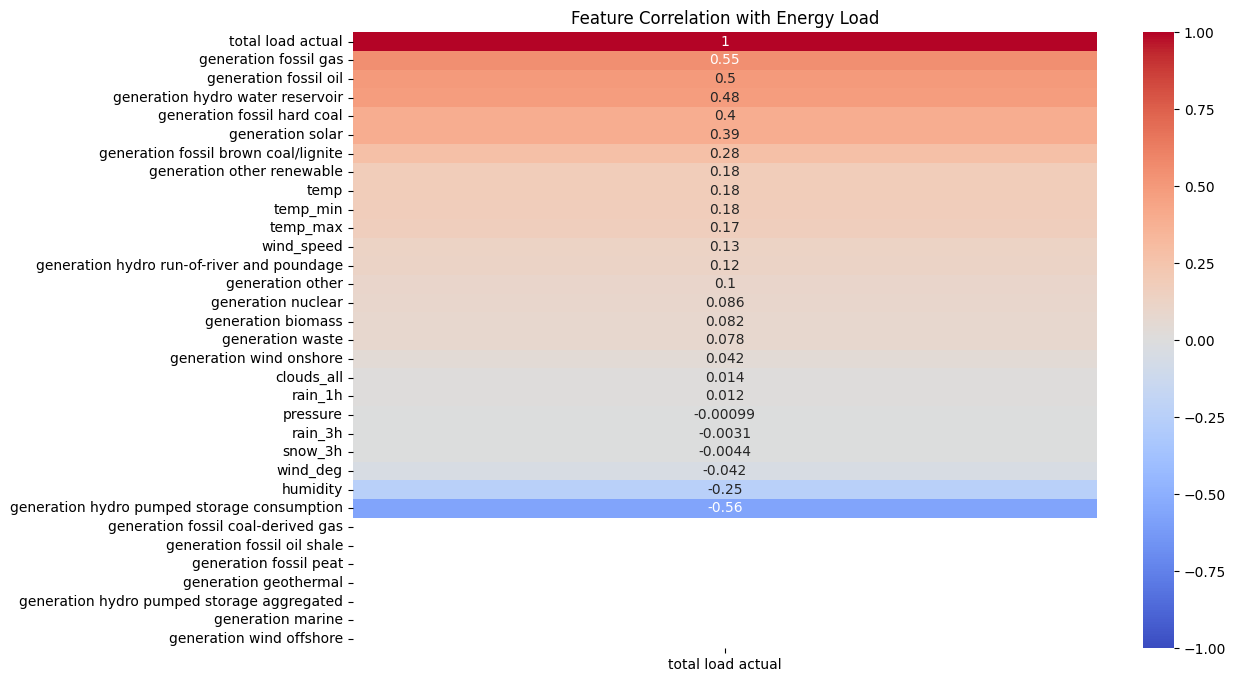


Selected Features:
['generation biomass', 'generation fossil brown coal/lignite', 'generation fossil coal-derived gas', 'generation fossil gas', 'generation fossil hard coal', 'generation fossil oil', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation hydro pumped storage aggregated', 'generation hydro pumped storage consumption', 'generation hydro run-of-river and poundage', 'generation hydro water reservoir', 'generation marine', 'generation nuclear', 'generation other', 'generation other renewable', 'generation solar', 'generation waste', 'generation wind offshore', 'generation wind onshore', 'temp', 'temp_min', 'temp_max', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all']


In [20]:
# 4. Feature Engineering with Correlation Analysis
print("\nSTEP 4: Feature Selection")
target_column = 'total load actual'
exclude_cols = [
    target_column, 'city_name', 'price day ahead', 'price actual',
    'forecast solar day ahead', 'forecast wind offshore eday ahead',
    'forecast wind onshore day ahead', 'total load forecast', 'time'
]
feature_cols = [col for col in data.columns if col not in exclude_cols]

# Correlation matrix for selected features
plt.figure(figsize=(12, 8))
corr_matrix = data[feature_cols + [target_column]].corr()
sns.heatmap(corr_matrix[[target_column]].sort_values(by=target_column, ascending=False),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation with Energy Load')
plt.show()

print("\nSelected Features:")
print(feature_cols)
print("="*50)


STEP 5: Time-Based Train-Test Split


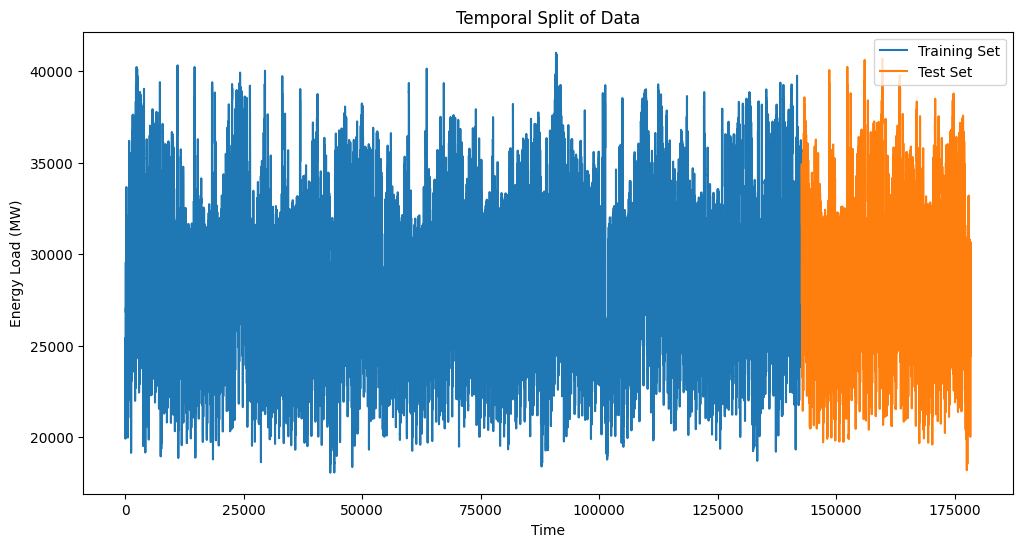

Training set size: 142716 samples
Test set size: 35680 samples


In [21]:
# 5. Train-Test Split with Visualization
print("\nSTEP 5: Time-Based Train-Test Split")
train_size = int(0.8 * len(data))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

plt.figure(figsize=(12, 6))
plt.plot(y_train.index, y_train, label='Training Set')
plt.plot(y_test.index, y_test, label='Test Set')
plt.title('Temporal Split of Data')
plt.xlabel('Time')
plt.ylabel('Energy Load (MW)')
plt.legend()
plt.show()

print(f"Training set size: {len(X_train)} samples")
print(f"Test set size: {len(X_test)} samples")
print("="*50)


STEP 6: Model Training with TimeSeriesSplit


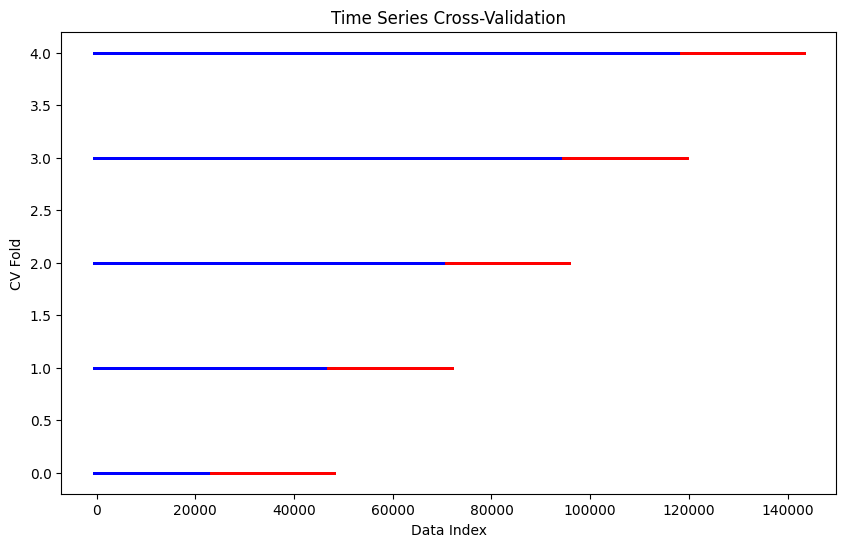


Starting Grid Search...
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Grid Search Completed!

Best Parameters: {'max_depth': 10, 'n_estimators': 20}
Best CV MSE: 3784305.6194283874


In [22]:
# 6. Model Training with Cross-Validation
print("\nSTEP 6: Model Training with TimeSeriesSplit")
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

plt.figure(figsize=(10, 6))
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
    plt.plot(train_index, [i]*len(train_index), 'b_')
    plt.plot(test_index, [i]*len(test_index), 'r_')
plt.title('Time Series Cross-Validation')
plt.xlabel('Data Index')
plt.ylabel('CV Fold')
plt.show()

param_grid = {
    'n_estimators': [10, 20],
    'max_depth': [5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                          cv=tscv, scoring='neg_mean_squared_error',
                          n_jobs=1, verbose=1)

print("\nStarting Grid Search...")
grid_search.fit(X_train, y_train)
print("\nGrid Search Completed!")

best_rf = grid_search.best_estimator_
print("\nBest Parameters:", grid_search.best_params_)
print("Best CV MSE:", -grid_search.best_score_)
print("="*50)


STEP 7: Model Evaluation


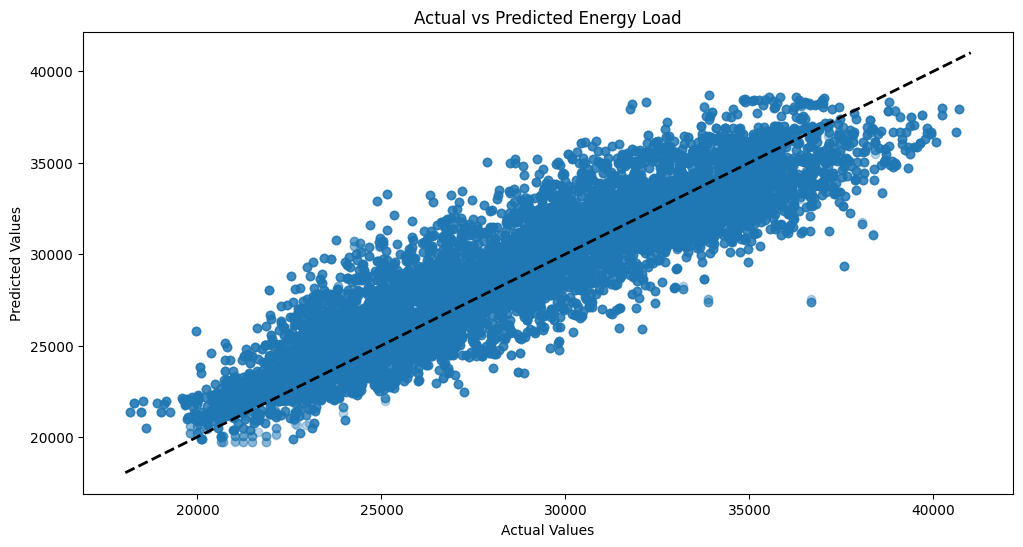

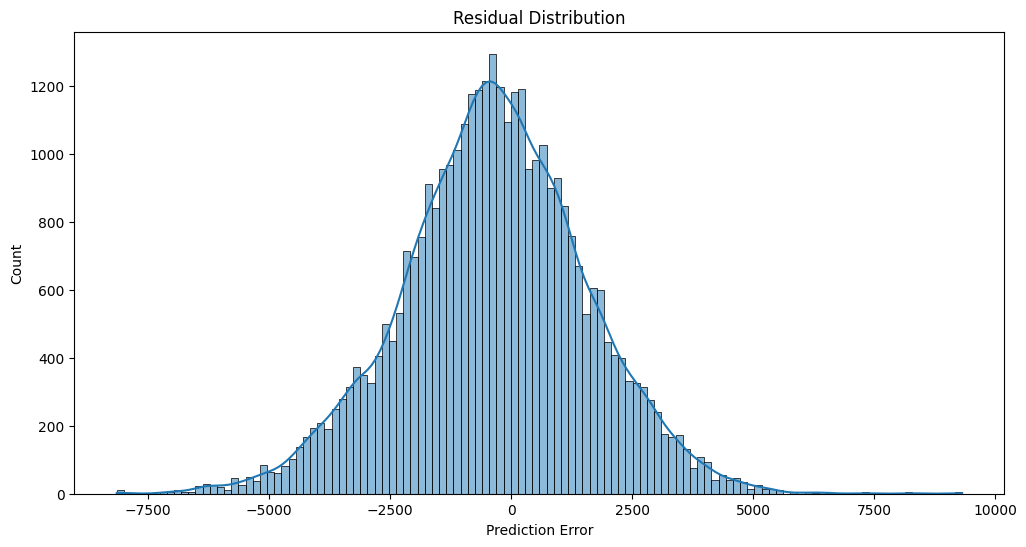


Test R²: 0.814
Test MSE: 3801842.05


In [23]:
# 7. Model Evaluation with Diagnostic Plots
print("\nSTEP 7: Model Evaluation")
y_pred = best_rf.predict(X_test)

plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Energy Load')
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(12, 6))
sns.histplot(residuals, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Prediction Error')
plt.show()

print(f"\nTest R²: {r2_score(y_test, y_pred):.3f}")
print(f"Test MSE: {mean_squared_error(y_test, y_pred):.2f}")
print("="*50)



STEP 8: Feature Importance Analysis


<ipython-input-24-6e2995f4a35f>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature',


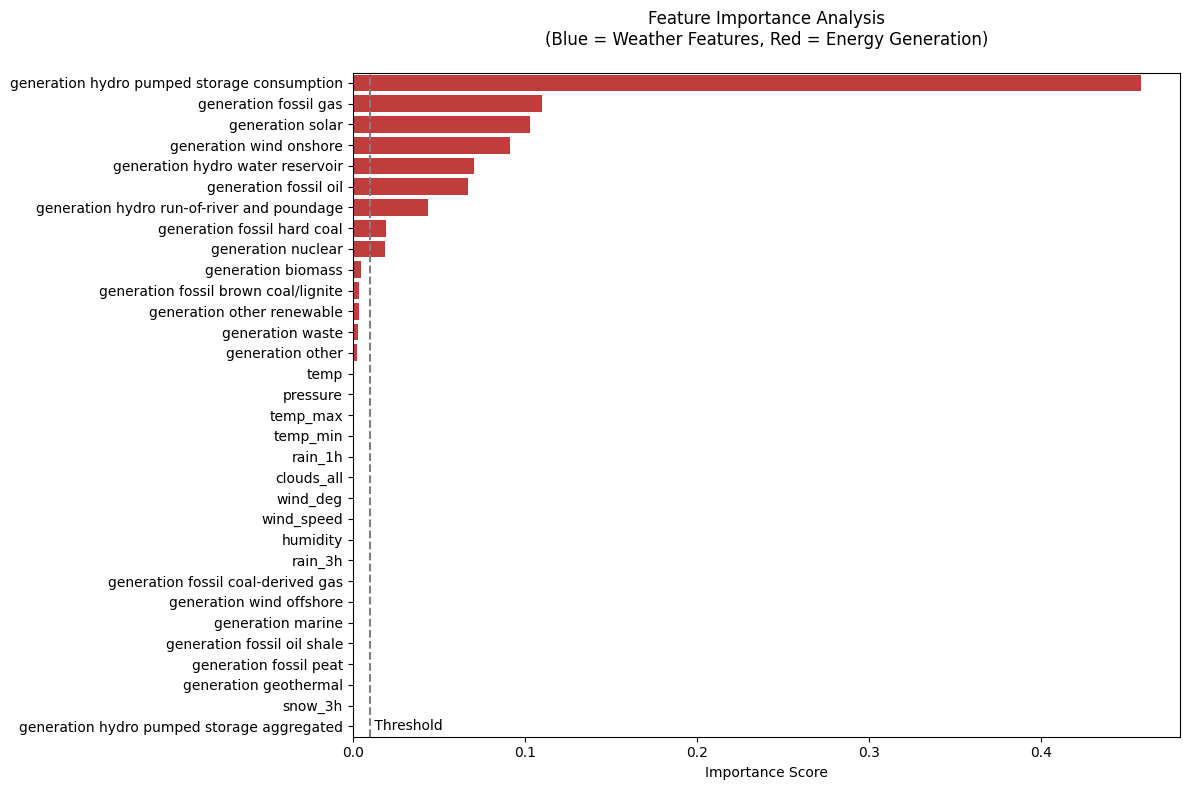


Top 10 Features:
                                        Feature  Importance
10  generation hydro pumped storage consumption    0.457564
3                         generation fossil gas    0.110136
17                             generation solar    0.103091
20                      generation wind onshore    0.091414
12             generation hydro water reservoir    0.070519
5                         generation fossil oil    0.067210
11   generation hydro run-of-river and poundage    0.043833
4                   generation fossil hard coal    0.019279
14                           generation nuclear    0.018534
0                            generation biomass    0.004627

Key Weather Features:
     Feature  Importance
21      temp    0.000543
24  pressure    0.000228
23  temp_max    0.000177
22  temp_min    0.000154
28   rain_1h    0.000005


In [24]:
# 8. Enhanced Feature Importance Analysis
print("\nSTEP 8: Feature Importance Analysis")
importances = best_rf.feature_importances_
feature_names = X.columns

importance_df = pd.DataFrame({'Feature': feature_names,
                             'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

weather_features = {
    'temp', 'temp_min', 'temp_max', 'pressure', 'humidity',
    'wind_speed', 'wind_deg', 'rain_1h', 'rain_3h', 'snow_3h', 'clouds_all'
}

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature',
           data=importance_df,
           palette=['#1f77b4' if feat in weather_features else '#d62728'
                    for feat in importance_df['Feature']])
plt.title('Feature Importance Analysis\n(Blue = Weather Features, Red = Energy Generation)', pad=20)
plt.xlabel('Importance Score')
plt.ylabel('')
plt.axvline(x=0.01, color='gray', linestyle='--')
plt.text(0.01, len(importance_df)-1, ' Threshold', ha='left', va='center')
plt.tight_layout()
plt.show()

print("\nTop 10 Features:")
print(importance_df.head(10))
print("\nKey Weather Features:")
print(importance_df[importance_df['Feature'].isin(weather_features)].head(5))
print("="*50)